# Introduction

This my first pass at trying to check if my star parameters worked.

I used the version of star and the annotation files included in the 10x cellranger-arc archive as the closest check I could manage.

I had used STAR 2.7.8a for some of my other tests as the released version of 2.7.9a had a bug. But unforutnately 2.7.8a crashed with a double free error. (And illegal instruction on some other machines, probably older).

So I had to use the prebuilt STAR from tag 2.7.9a_2021-06-25

In [1]:
import scipy
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot
import sys
import pysam
from collections import Counter

In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [3]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [4]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "SJ"]

    analysis_dir = Path(analysis_dir)
    feature_name = "features.tsv"
    
    solo_dir = analysis_dir / "Solo.out" / quantification / mode
    solo = scanpy.read_mtx(solo_dir / "matrix.mtx").T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



In [5]:
tenx_root = Path('ENCSR724KET_cr-arc')
tenx_raw_path = tenx_root / 'outs' / 'raw_feature_bc_matrix'
tenx_filtered_path = tenx_root / 'outs' / 'filtered_feature_bc_matrix'

In [6]:
tenx_filtered = scanpy.read_10x_mtx(tenx_filtered_path, var_names='gene_ids')
tenx_filtered.obs_names = [x[:-2] for x in tenx_filtered.obs_names]

In [7]:
solo278a_root = Path("starsolo_2.7.9a_2021-06-25_cr-compatibility")
solo278a_gene = scanpy_load_solo278a_mtx(solo278a_root, "Gene", "filtered")
solo278a_genefull = scanpy_load_solo278a_mtx(solo278a_root, "GeneFull", "filtered")

In [8]:
print("tenx filtered", tenx_filtered.shape, tenx_filtered.X.sum())
print("solo gene", solo278a_gene.shape, solo278a_gene.X.sum())
print("solo genefull", solo278a_genefull.shape, solo278a_genefull.X.sum())

tenx filtered (13650, 36601) 80119070.0
solo gene (14389, 36601) 41349504.0
solo genefull (15906, 36601) 110782640.0


solo gene is empty? That's really weird

In [9]:
common_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo278a_gene.obs_names)]

In [10]:
solo278a_filtered_gene = solo278a_gene[common_barcodes,:]
solo278a_filtered_gene.shape, solo278a_filtered_gene.X.sum()

((12834, 36601), 39354188.0)

In [11]:
solo278a_filtered_gene.X.sum(axis=1).shape

(12834, 1)

In [12]:
tenx_common = tenx_filtered[common_barcodes,:]

In [13]:
filtered_cors = compute_spearman_anndata(tenx_common, solo278a_filtered_gene)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [14]:
tenx_common

View of AnnData object with n_obs × n_vars = 12834 × 36601
    var: 'gene_symbols', 'feature_types'

In [15]:
tenx_common_sum = pandas.Series(numpy.asarray(tenx_common.X.sum(axis=1)).T[0])


In [16]:
tenx_idxmax = tenx_common_sum.idxmax()
tenx_max_cell = tenx_common.obs_names[tenx_idxmax]
tenx_max_cell

'GCATCCTTCTAAGTGC'

In [17]:
tfg = tenx_filtered[tenx_max_cell].to_df().T
tfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.866807
std,72.393562
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13634.000000


In [18]:
sfg = solo278a_filtered_gene[tenx_max_cell].to_df().T
sfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,1.805169
std,75.464264
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,14372.000000


In [19]:
assert numpy.all(tfg.index == sfg.index), "feature lists are not in same order "

In [20]:
rad = (numpy.abs(sfg - tfg) / numpy.maximum(sfg, tfg))

<AxesSubplot:ylabel='Frequency'>

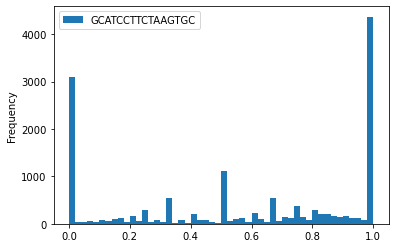

In [21]:
rad.plot.hist(bins=50)

In [22]:
combined_gene = pandas.merge(sfg, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo gene

<ipython-input-23-3fd4f3200269>:4: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)


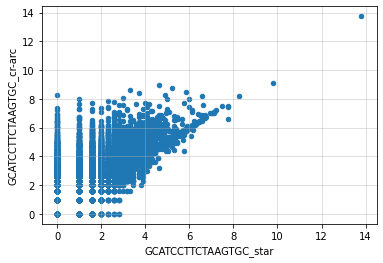

In [23]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0,1e5)
#ax.set_ylim(0,1e5)
ax.grid(alpha=.5)

Wait a second... that looks like cell ranger has higher expression... what did they change? Are they counting introns? Multireads?

In [24]:
gene_cors = compute_spearman_anndata(tenx_common, solo278a_filtered_gene)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Compare per cell gene spearman correlation

There is a warning message from the spearman function complaining that the input matrix has an issue, so this histogram may be incorrect.

<AxesSubplot:ylabel='Frequency'>

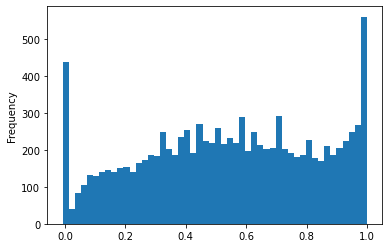

In [25]:
gene_cors.plot.hist(bins=50)

# Prepare GeneFull comparisons

In [26]:
common_genefull_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo278a_genefull.obs_names)]
solo278a_filtered_genefull = solo278a_genefull[common_genefull_barcodes,:]
sfgf = solo278a_filtered_genefull[tenx_max_cell].to_df().T
sfgf.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,5.443458
std,76.680756
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,14161.000000


In [27]:
combined_genefull = pandas.merge(sfgf, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

In [28]:
def plot_cell(star, cr, cell):
    star_cell = star[cell].to_df().T
    cr_cell = cr[cell].to_df().T
    combined = pandas.merge(star_cell, cr_cell, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))
    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)

    p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xlim(0,1e5)
    #ax.set_ylim(0,1e5)
    ax.grid(alpha=.5)

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo genefull

<ipython-input-28-35c547c9dd5b>:8: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)


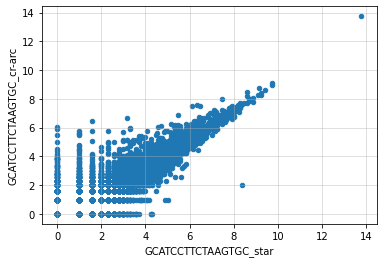

In [29]:
plot_cell(solo278a_filtered_genefull, tenx_filtered, tenx_max_cell)

In [30]:
tenx_common_genefull = tenx_filtered[common_genefull_barcodes,:]
genefull_cors = compute_spearman_anndata(tenx_common_genefull, solo278a_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Plot GeneFull correlations

Text(0.5, 0, 'Spearman correlation')

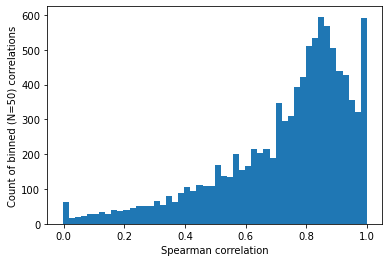

In [31]:
ax = genefull_cors.plot.hist(bins=50)
ax.set_ylabel("Count of binned (N=50) correlations")
ax.set_xlabel("Spearman correlation")

Well that's an improvement. Looks like they're counting introns.

In [32]:
genefull_cors[(genefull_cors > 0.8) & (genefull_cors < 0.81)]

AAAGGTTAGCGATACT    0.805665
AACCTAATCCCTGGAA    0.808631
AACCTAATCTTAGCCC    0.808021
AACCTTAAGGCAAGTA    0.803021
AAGCATGAGGCTTAGT    0.809463
                      ...   
TTTGACTTCCCTGGAA    0.804569
TTTGACTTCCTCCTAA    0.802997
TTTGTCCCATAGGCGA    0.803183
TTTGTCTAGCTGTACG    0.806958
TTTGTGTTCTAAGTCA    0.806965
Length: 220, dtype: float64

In [33]:
cell_id = genefull_cors[(genefull_cors > 0.8) & (genefull_cors < 0.81)].index[0]

<ipython-input-28-35c547c9dd5b>:8: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)


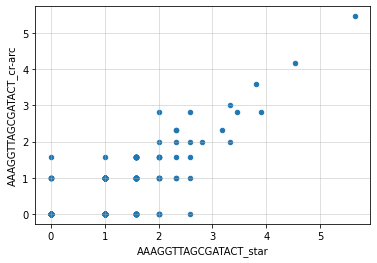

In [34]:
plot_cell(solo278a_filtered_genefull, tenx_filtered, cell_id)

In [35]:
ok_solo_cell = solo278a_filtered_genefull[cell_id].to_df().T
ok_cr_cell = tenx_common_genefull[cell_id].to_df().T

ok_cells = pandas.merge(ok_solo_cell, ok_cr_cell, left_index=True, right_index=True, suffixes=("_solo", "_cr"))



In [36]:
different =  (ok_cells['AAAGGTTAGCGATACT_solo'] != ok_cells['AAAGGTTAGCGATACT_cr'])


In [37]:
ok_cells[different].sort_values(by="AAAGGTTAGCGATACT_solo")

,AAAGGTTAGCGATACT_solo,AAAGGTTAGCGATACT_cr
ENSG00000197555,0.0,2.0
ENSG00000254787,0.0,1.0
ENSG00000134627,0.0,1.0
ENSG00000118181,0.0,1.0
ENSG00000145439,0.0,1.0
...,...,...
ENSG00000183722,11.0,7.0
ENSG00000166833,14.0,12.0
ENSG00000153823,15.0,7.0
ENSG00000196569,23.0,18.0


In [38]:
store = pandas.HDFStore("/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/GRCh38-arc2.0-2.7.8a/GRCh38-arc2.0-2.7.8a.h5")
gtf = store["/gtf"]
store.close()

In [39]:
gene = gtf[(gtf["gene_id"] == "ENSG00000153823") & (gtf["type"] == "gene")].loc[440211]
ensg_153823

NameError: name 'ensg_153823' is not defined

In [ ]:
tenx_bam = pysam.AlignmentFile(tenx_root / "outs" / "gex_possorted_bam.bam", "rb")
solo_bam = pysam.AlignmentFile(solo278a_root / "Aligned.sortedByCoord.out.bam", "rb")

In [ ]:
tenx_all_reads = list(tenx_bam.fetch(ensg_153823.chromosome, ensg_153823.start, ensg_153823.stop))
solo_all_reads = list(solo_bam.fetch(ensg_153823.chromosome, ensg_153823.start, ensg_153823.stop))
print("Solo len={}, CR len={}".format(len(solo_all_reads), len(tenx_all_reads)))

X_all_reads is everything in this tenx run, so is many libraries and many UMIs.

In [ ]:
tenx_cell_id = cell_id + "-1"
tenx_reads = [x for x in tenx_all_reads if x.has_tag("CB") and x.get_tag("CB") == tenx_cell_id]
solo_reads = [x for x in solo_all_reads if x.has_tag("CB") and x.get_tag("CB") == cell_id]
print("Solo len={}, CR len={}".format(len(solo_reads), len(tenx_reads)))

In [ ]:
set([x.query_name for x in tenx_reads]).symmetric_difference([x.query_name for x in solo_reads])

In [ ]:
[x.to_string() for x in tenx_all_reads if x.query_name == 'A00509:187:HYHY3DRXX:1:2264:19081:23766']

In [ ]:
[x.to_string() for x in solo_all_reads if x.query_name == 'A00509:187:HYHY3DRXX:1:2264:19081:23766']

In [ ]:
tenx_umis = Counter([x.get_tag("UR") for x in tenx_reads])
len(tenx_umis)

In [ ]:
cell_id == 'AAAGGTTAGCGATACT'

In [ ]:
read.tags['CB']

In [ ]:
(2 ** 16) * 9